In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from datetime import datetime
import random
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
file_path = f'data/yahoo/merged_financials_quotes_markers.json'
with open(file_path, 'r') as json_file:
    financial_data = json.load(json_file)

In [4]:
tickers = list(financial_data.keys())

In [5]:
print(financial_data[tickers[0]].keys())

dict_keys(['quarterly_income', 'quarterly_balance', 'quarterly_cashflow', 'annual_income', 'annual_balance', 'annual_cashflow', 'quotes', 'quarterly_markers', 'annual_markers', 'quotes_stats'])


In [6]:
print(financial_data[tickers[0]]['quotes_stats']['2023']['stats'].keys())
print(financial_data[tickers[0]]['annual_markers'][0]['1604098800'].keys())

dict_keys(['low', 'high', 'volume', 'volumePrice', 'spread', 'averagePrice', 'averageDailySpread', 'averageMonthlySpread', 'missingDays', 'missingMonths'])
dict_keys(['marketcap', 'price/earnings', 'price/equity', 'price/tangibleBookValue', 'netIncomeMargin', 'grossProfitMargin', 'ebitMargin', 'ebitdaMargin', 'operatingIncomeMargin', 'operatingCashFlowMargin', 'investingCashFlowMargin', 'freeCashFlowMargin', 'debt/assets', 'netIncome/equity', 'netIncome/tangibleBookValue', 'netIncome/totalAssets'])


In [7]:
def get_fig_ax(num_rows=1, num_cols=1, figsize=(6, 4)):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Add grid to all plots
    if num_rows == 1 and num_cols == 1:
        ax.grid(True, which='both')
    elif num_rows != 1 and num_cols != 1:
        for i in range(num_rows):
            for j in range(num_cols):
                ax[i, j].grid(True, which='both')
    else:
        for i in range(max(num_rows, num_cols)):
            ax[i].grid(True, which='both')

    return fig, ax

In [8]:
selected_flattened_financials = {ticker: {} for ticker in tickers}

In [9]:
def get_latest_timestamp(timestamps):
    latest_timestamp = 0
    for timestamp in timestamps:
        timestamp = int(timestamp)
        if timestamp > latest_timestamp:
            latest_timestamp = timestamp
    return str(latest_timestamp)

In [10]:
for ticker in tickers:
    # Get the latest timestamp for the annual markers
    latest_timestamp = get_latest_timestamp([list(i.keys())[0] for i in financial_data[ticker]['annual_markers']])

    if latest_timestamp == '0':
        continue

    for markers in financial_data[ticker]['annual_markers']:
        # Select markers with the latest timestamp
        if list(markers.keys())[0] == latest_timestamp:
            latest_markers = markers

    selected_flattened_financials[ticker]['markers_timestamp'] = latest_timestamp
    selected_flattened_financials[ticker]['marketcap'] = latest_markers[latest_timestamp]['marketcap']
    selected_flattened_financials[ticker]['price/earnings'] = latest_markers[latest_timestamp]['price/earnings']

# P/E
P/E - price to earnings, stosunek rocznego (lub ekstrapolowanego na roczny) zysku netto do wyceny rynkowej spółki (marketcap). Jeden z postawowych wksaźników brany pod uwagę przy analizie adekwatności wyceny rynkowej spółki. Im P/E mniejsze, tym spółka tańsza.

In [11]:
marketcaps = np.array([selected_flattened_financials[ticker]['marketcap'] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys()])
prince_to_earnings = np.array([[selected_flattened_financials[ticker]['price/earnings']] for ticker in tickers if 'price/earnings' in selected_flattened_financials[ticker].keys()])

Text(0, 0.5, 'Price to earnings ratio')

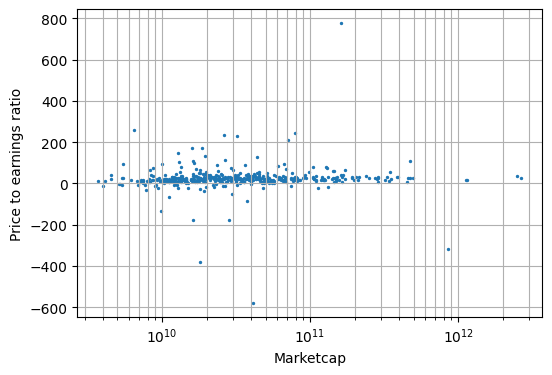

In [12]:
# Plot price to earnings ratio vs marketcaps
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, prince_to_earnings, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Price to earnings ratio')

Jak widać na wykresie, marektcap różni się znacznie między firmami. Ze względu na małą ilość próbek, odfiltrowaliśmy firmy o marketcapi > 50*10^10.

In [13]:
# Filter out pairs with marketcp > 5*10^11
marketcaps_filtered = marketcaps[marketcaps < 5*10**11]
prince_to_earnings_filtered = prince_to_earnings[marketcaps < 5*10**11]

Wskaźnik P/E jest z punktu widzenia naszej analizy problematyczny, ponieważ:
- Zakres wrtości jest bardzo duży (od ok. -600 do ok. 800)
- Firmy wykazujące pomijalnie mały zysk lub pomijalnie małą stratę mają dużą wartość bezwzględną wskaźnika P/E
- Firmy o podobnej wycenie, różniące się nieznacznie zyskami, są znacznie oddalone od siebie na osi P/E, podczas gdy firmy zacznie różniące się zyskami są blisko siebie. Jest to nieintuicyjne

Z tych powodów postanowiliśmy odwrócić wskaźnik (E/P = 1/(P/E)) i poddać go analizie

In [14]:
earnings_to_price_filtered = 1 / prince_to_earnings_filtered

Text(0, 0.5, 'Earnings to price ratio')

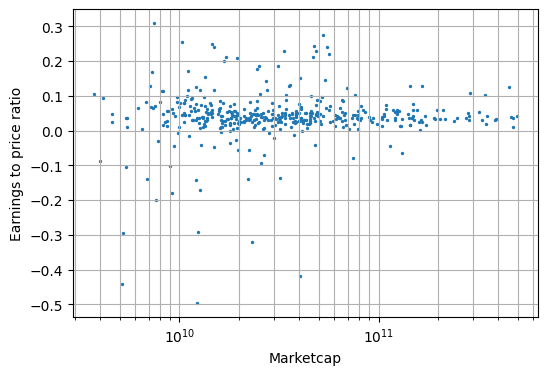

In [15]:
# Plot earnings to price ratio vs marketcaps
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps_filtered, earnings_to_price_filtered, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Earnings to price ratio')

Wnioski: 
- Znaczna większość firm wykazuje zyski (E/P, P/E > 0).
- Niewiele jest firm z E/P > 0,1. Jeżeli jednak firma ma E/P większe niż 0,1 to z dużym prawdopodobieństwem jest ono znacznie więsze niż 0,1. Takie firmy mogą być dobrymi okazjami do inwestycji, o ile jej niska wycena nie wynika z problemów danej firmy.
- Jeżeli firma wykazuje stratę, to jest ona przeważnie bardzo duża w stosunku do wyceny rynkowej firmy. Możlie przyczyny:
  - Bardzo negatywna reakcja inwestorów na informaję o stratach i znaczny spadek wyceny
  - Straty mogą wynikać z niespodziwanych sytuacji o dużym wpływie na rentowność, których firma nie była w stanie przewidzieć, a co za tym idzie, zaadaptować się. Takie sytuacje prowadzą zwykle do dużych strat.
  - Straty wynikające z nagłych zdarzeń, awarii, katastrof itp. (fat tail)
- Bardzo duże firmy (> ok. 100 mld USD) żadko wykazują straty
- Im większa firma, tym mniejsze prawdopodobieństwo i skala strat (survivor bias? wzrost + lindy effect?)

Do E/P i wyceny dopasowaliśmy wielomian 8 stopnia, aby zobaczyć zależności.

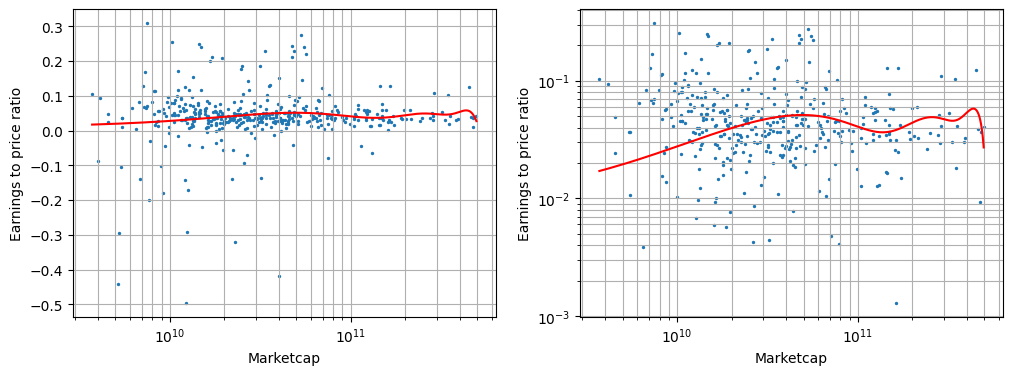

In [16]:
# Fit a polynomial to the data
polynomial_fit = np.polyfit(marketcaps_filtered, earnings_to_price_filtered, 8)

x = np.linspace(np.min(marketcaps_filtered), np.max(marketcaps_filtered), 1000)
polynomial_values = np.polyval(polynomial_fit, x)

fig, ax = get_fig_ax(num_cols=2, figsize=(12, 4))

ax[0].set_xlabel('Marketcap')
ax[0].set_ylabel('Earnings to price ratio')
ax[0].set_xscale('log')
ax[0].scatter(marketcaps_filtered, earnings_to_price_filtered, s=2)
ax[0].plot(x, polynomial_values, color='red')

ax[1].set_xlabel('Marketcap')
ax[1].set_ylabel('Earnings to price ratio')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].scatter(marketcaps_filtered, earnings_to_price_filtered, s=2)
ax[1].plot(x, polynomial_values, color='red')

Wnioski:
- E/P rośnie wraz z wyceną firmy do ok. 50 mld USD, potem maleje i osiąga lokalne miniumum powyżej 100 mld USD. Dalej rośnie, ale nie możemy z być tego pewni ze względu na małą lczność danych dla tak dużych firm.
- E/P dla małych firm jest zaniżane przez firmy wykazujące straty

# Some stuff

# TODO
- Podać jak zdefiniowaliśmy średni miesięczny i roczny spread

In [17]:
# Get average daily spread in a year for all tickers
for ticker in tickers:
    year = '2022'
    selected_flattened_financials[ticker]['spreadIn2022'] = financial_data[ticker]['quotes_stats'][year]['stats']['spread']
    selected_flattened_financials[ticker]['averageDailySpreadIn2022'] = financial_data[ticker]['quotes_stats'][year]['stats']['averageDailySpread']
    selected_flattened_financials[ticker]['averageMontlySpreadIn2022'] = financial_data[ticker]['quotes_stats'][year]['stats']['averageMonthlySpread']

In [18]:
# Get markecap and spread for all companies with:
# - marketcap not None
# - marketcap > 5*10^11
# - spread not None
marketcaps = []
spreads = []
for ticker in tickers:
    marketcap = selected_flattened_financials[ticker]['marketcap'] if 'marketcap' in selected_flattened_financials[ticker].keys() else None
    spread = selected_flattened_financials[ticker]['spreadIn2022'] if 'spreadIn2022' in selected_flattened_financials[ticker].keys() else None

    if marketcap is None:
        continue

    if marketcap > 5*10**11:
        continue

    if spread is None:
        continue

    marketcaps.append(marketcap)
    spreads.append(spread)

Text(0, 0.5, 'Spread')

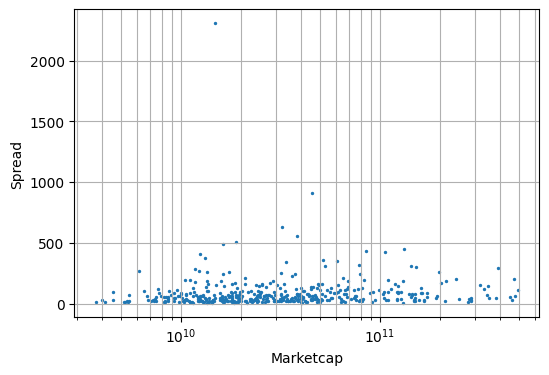

In [19]:
# Plot spread vs marketcap
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, spreads, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Spread')

# TODO
- Odfiltrować elementy nietypowe
- Wnioski o spreadzie w zależności od marketcapu (dopasowanie wielomianu?)

In [20]:
# Get average monthly spread and marketcap for all companies with:
# - marketcap not None
# - marketcap > 5*10^11
# - averageMonthlySpread not None
marketcaps = []
spreads = []
for ticker in tickers:
    marketcap = selected_flattened_financials[ticker]['marketcap'] if 'marketcap' in selected_flattened_financials[ticker].keys() else None
    spread = selected_flattened_financials[ticker]['averageMontlySpreadIn2022'] if 'averageMontlySpreadIn2022' in selected_flattened_financials[ticker].keys() else None

    if marketcap is None:
        continue

    if marketcap > 5*10**11:
        continue

    if spread is None:
        continue

    marketcaps.append(marketcap)
    spreads.append(spread)

Text(0, 0.5, 'Average monthly spread')

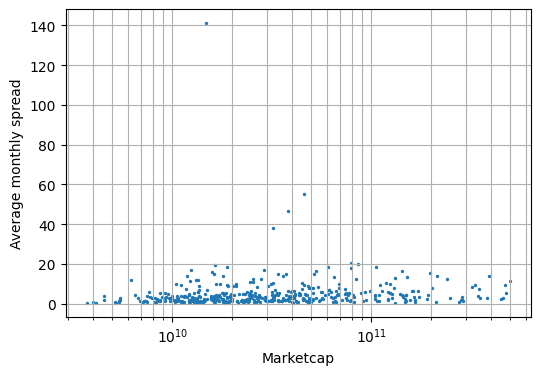

In [21]:
# Plot spread vs marketcap
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, spreads, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Average monthly spread')

# TODO
Jak dla spreadu

In [22]:
# Get average daily spread and marketcap for all companies with:
# - marketcap not None
# - marketcap > 5*10^11
# - averageDailySpread not None
marketcaps = []
spreads = []
for ticker in tickers:
    marketcap = selected_flattened_financials[ticker]['marketcap'] if 'marketcap' in selected_flattened_financials[ticker].keys() else None
    spread = selected_flattened_financials[ticker]['averageDailySpreadIn2022'] if 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() else None

    if marketcap is None:
        continue

    if marketcap > 5*10**11:
        continue

    if spread is None:
        continue

    marketcaps.append(marketcap)
    spreads.append(spread)

Text(0, 0.5, 'Average daily spread')

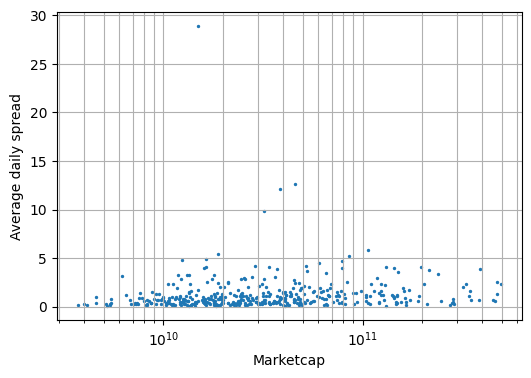

In [23]:
# Plot spread vs marketcap
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, spreads, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Average daily spread')

# TODO
- Jak dla spreadu
- Znaleźć przyczyny dużego spreadu dla tych 4 wyróżniających się spółek

In [59]:
# For all tickers get the following:
# - net income margin
# - ebit margin
# - ebitda margin
# - debt to assets
# - net income to equity
# - net income to tangible book value
# - net income to assets
for ticker in tickers:
    # Get the latest timestamp for the annual markers
    latest_timestamp = get_latest_timestamp([list(i.keys())[0] for i in financial_data[ticker]['annual_markers']])

    if latest_timestamp == '0':
        continue

    for markers in financial_data[ticker]['annual_markers']:
        # Select markers with the latest timestamp
        if list(markers.keys())[0] == latest_timestamp:
            latest_markers = markers

    selected_flattened_financials[ticker]['netIncomeMargin'] = latest_markers[latest_timestamp]['netIncomeMargin']
    selected_flattened_financials[ticker]['ebitMargin'] = latest_markers[latest_timestamp]['ebitMargin']
    selected_flattened_financials[ticker]['ebitdaMargin'] = latest_markers[latest_timestamp]['ebitdaMargin']
    selected_flattened_financials[ticker]['debt/assets'] = latest_markers[latest_timestamp]['debt/assets']
    selected_flattened_financials[ticker]['netIncome/equity'] = latest_markers[latest_timestamp]['netIncome/equity']
    selected_flattened_financials[ticker]['netIncome/tangibleBookValue'] = latest_markers[latest_timestamp]['netIncome/tangibleBookValue']
    selected_flattened_financials[ticker]['netIncome/totalAssets'] = latest_markers[latest_timestamp]['netIncome/totalAssets']

In [30]:
# Get ebida margin, net income margin, and debt/assets for all companies with:
# - ebitdaMargin not None
# - netIncomeMargin not None
# - debt/assets not None
ebitda_margins = []
net_income_margins = []
debt_to_assets = []
for ticker in tickers:
    ebitda_margin = selected_flattened_financials[ticker]['ebitdaMargin'] if 'ebitdaMargin' in selected_flattened_financials[ticker].keys() else None
    net_income_margin = selected_flattened_financials[ticker]['netIncomeMargin'] if 'netIncomeMargin' in selected_flattened_financials[ticker].keys() else None
    debt_to_asset = selected_flattened_financials[ticker]['debt/assets'] if 'debt/assets' in selected_flattened_financials[ticker].keys() else None

    if ebitda_margin is None:
        continue

    if net_income_margin is None:
        continue

    if debt_to_asset is None:
        continue

    ebitda_margins.append(ebitda_margin)
    net_income_margins.append(net_income_margin)
    debt_to_assets.append(debt_to_asset)


Text(0, 0.5, 'Net income margin')

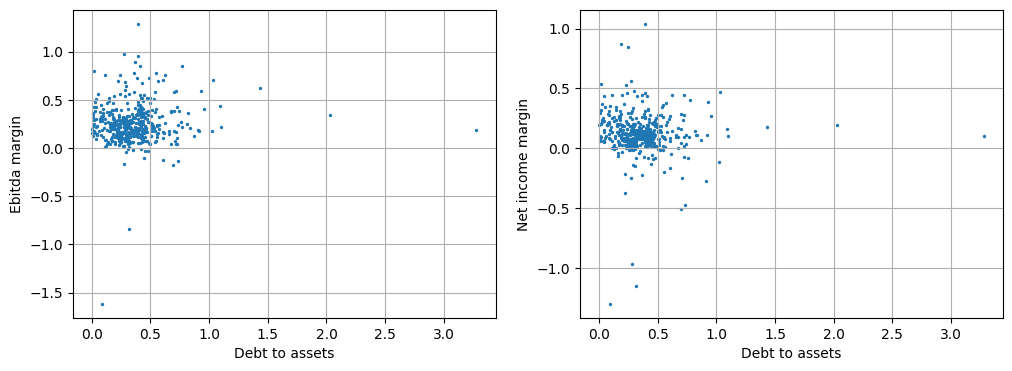

In [35]:
# Plot ebitda margin vs debt to assets and net income margin vs debt to assets
fig, ax = get_fig_ax(num_cols=2, figsize=(12, 4))

ax[0].scatter(debt_to_assets, ebitda_margins, s=2)
ax[0].set_xlabel('Debt to assets')
ax[0].set_ylabel('Ebitda margin')

ax[1].scatter(debt_to_assets, net_income_margins, s=2)
ax[1].set_xlabel('Debt to assets')
ax[1].set_ylabel('Net income margin')

Wniosek: nie ma zależności między marżą EBITDA i stosunkiem długu do aktywów

# TODO
Odfiltrować wartści nietypowe i dodać wykresy powyżej

# TODO
Wersja tego poniżej i wykresy bez filtrowania

In [81]:
# Get net income to equity, net income to tangible book value, debt to assets for all companies with:
# - netIncome/equity not None
# - netIncome/equity < 5 and > -5
# - netIncome/tangibleBookValue not None
# - netIncome/tangibleBookValue < 5 and > -5
# - debt/assets not None
# - debt/assets < 1.5
net_income_to_equities = []
net_income_to_tangible_book_values = []
debt_to_assets = []
for ticker in tickers:
    net_income_to_equity_value = selected_flattened_financials[ticker]['netIncome/equity'] if 'netIncome/equity' in selected_flattened_financials[ticker].keys() else None
    tangible_book_value_value = selected_flattened_financials[ticker]['netIncome/tangibleBookValue'] if 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() else None
    debt_to_asset = selected_flattened_financials[ticker]['debt/assets'] if 'debt/assets' in selected_flattened_financials[ticker].keys() else None

    if net_income_to_equity_value is None:
        continue

    if net_income_to_equity_value > 5 or net_income_to_equity_value < -5:
        continue

    if tangible_book_value_value is None:
        continue

    if tangible_book_value_value > 5 or tangible_book_value_value < -5:
        continue

    if debt_to_asset is None:
        continue

    if debt_to_asset > 1.5:
        continue

    net_income_to_equities.append(net_income_to_equity_value)
    net_income_to_tangible_book_values.append(tangible_book_value_value)
    debt_to_assets.append(debt_to_asset)

Text(0, 0.5, 'Net income to equity')

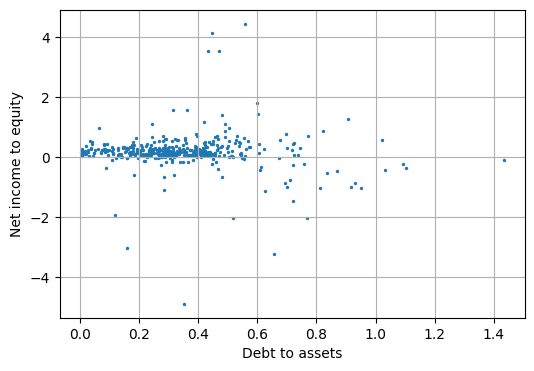

In [43]:
# Plot net income to equity vs debt to assets
fig, ax = get_fig_ax()
ax.scatter(debt_to_assets, net_income_to_equities, s=2)
ax.set_xlabel('Debt to assets')
ax.set_ylabel('Net income to equity')

Text(0, 0.5, 'Net income to tangible book value')

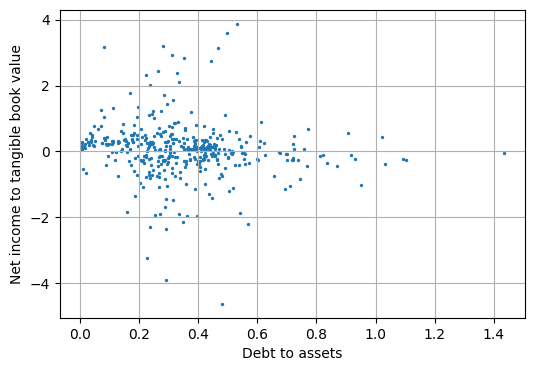

In [63]:
# plot net income to tangible book value vs debt to assets
fig, ax = get_fig_ax()
ax.scatter(debt_to_assets, net_income_to_tangible_book_values, s=2)
ax.set_xlabel('Debt to assets')
ax.set_ylabel('Net income to tangible book value')

Text(0, 0.5, 'Net income to tangible book value')

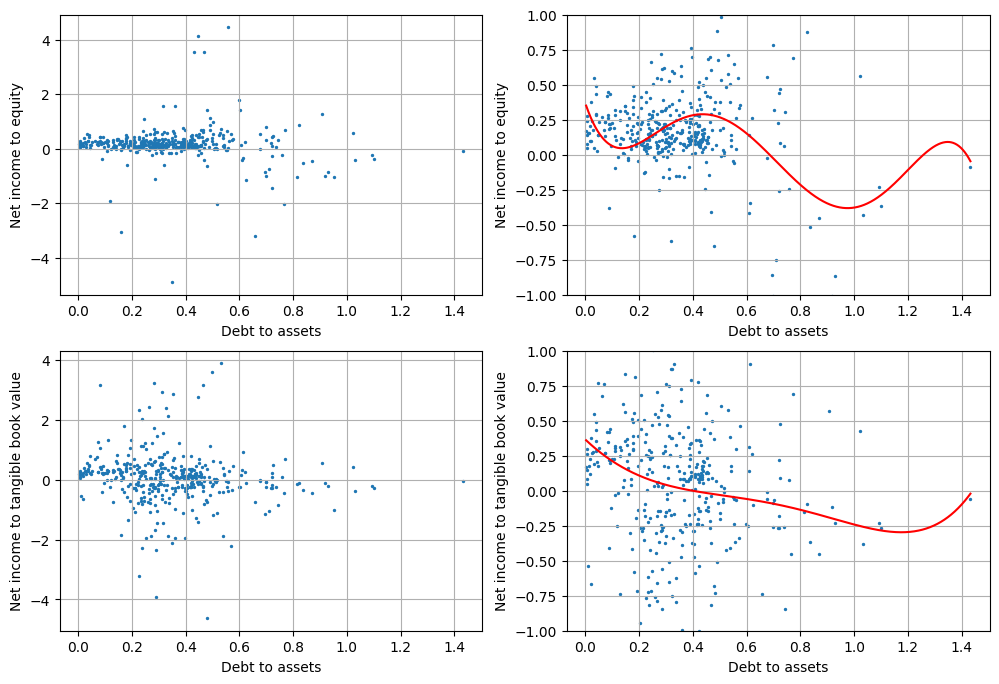

In [82]:
# Fit a polynomial to net income to equity vs debt to assets
net_income_to_equity_polynomial_fit = np.polyfit(debt_to_assets, net_income_to_equities, 5)

x = np.linspace(np.min(debt_to_assets), np.max(debt_to_assets), 1000)
net_income_to_equity_polynomial_values = np.polyval(net_income_to_equity_polynomial_fit, x)

# Fit a polynomial to net income to tangible book value vs debt to assets
net_income_to_tangible_book_value_polynomial_fit = np.polyfit(debt_to_assets, net_income_to_tangible_book_values, 5)

net_income_to_tangible_book_value_polynomial_values = np.polyval(net_income_to_tangible_book_value_polynomial_fit, x)

fig, ax = get_fig_ax(num_rows=2, num_cols=2, figsize=(12, 8))

ax[0, 0].scatter(debt_to_assets, net_income_to_equities, s=2)
ax[0, 0].set_xlabel('Debt to assets')
ax[0, 0].set_ylabel('Net income to equity')

ax[0, 1].scatter(debt_to_assets, net_income_to_equities, s=2)
ax[0, 1].plot(x, net_income_to_equity_polynomial_values, color='red')
ax[0, 1].set_ylim(-1, 1)
ax[0, 1].set_xlabel('Debt to assets')
ax[0, 1].set_ylabel('Net income to equity')

ax[1, 0].scatter(debt_to_assets, net_income_to_tangible_book_values, s=2)
ax[1, 0].set_xlabel('Debt to assets')
ax[1, 0].set_ylabel('Net income to tangible book value')

ax[1, 1].scatter(debt_to_assets, net_income_to_tangible_book_values, s=2)
ax[1, 1].plot(x, net_income_to_tangible_book_value_polynomial_values, color='red')
ax[1, 1].set_ylim(-1, 1)
ax[1, 1].set_xlabel('Debt to assets')
ax[1, 1].set_ylabel('Net income to tangible book value')

# ax[0].set_xlabel('Debt to assets')
# ax[0].set_ylabel('Net income to equity')
# ax[0].scatter(debt_to_assets, net_income_to_equity, s=2)

# ax[1].set_xlabel('Debt to assets')
# ax[1].set_ylabel('Net income to equity')
# ax[1].set_ylim(-1, 1)
# # ax[1].set_ylim(-2, 2)
# ax[1].scatter(debt_to_assets, net_income_to_equity, s=2)
# ax[1].plot(x, polynomial_values, color='red')

Wnioski:
- Wraz ze wzrostem stosunku długu do aktywów rośnie wartość bezwzględna stosunku zysku netto do wartości księgowej. Sugeruje to, że inwestycje w firmy o większym stosunku zadłużenia do aktywów są zarówno bardziej ryzykowne, jak i skutkują więszymi zyskami i stratami.
- Największego wzrostu skali działalnoci z reinwestycji zysków możemy spodziewać się dla przedziału stosunku długu do aktywów to 0,3 - 0,5.
- Stosunek zysku netto do wartości księgowej ma maksimum lokalne we wcześniej wymienionym przedziale. Później zaczyna spadać.
- Dla wartości księgowej z wyłączniem dóbr niematerialnych mamy w przybliżeniu rozkład gaussowski.
- Dla wartości księgowej z wyłączeniem dóbr niematerialnych widzimy jednostajny spadek stosunku zysku netto do wartości księgowej wraz ze wzrostem zadłuzenia.